# XGBoost for Sink Particles
> Created Feb. 2025 <br>
> Nikhil Bisht<br>

In [16]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.json'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.85
NVALID_percentage =  0.05
NTEST_percentage  =  0.15

#ALL_COLUMNS = ['Initial_Frame', 'Particle_id', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f', 'Vx_f', 'Vy_f', 'Vz_f', 'Density_f']
#FEATURES = ALL_COLUMNS[0:9]
#TARGET = ALL_COLUMNS[9:]

ALL_COLUMNS = ['Particle_id','Initial_Frame' , 'X_i', 'Y_i', 'Z_i', 'X_f', 'Y_f', 'Z_f']
FEATURES = ALL_COLUMNS[1:5]
TARGET = ALL_COLUMNS[5:]

FRAMESTRAIN = np.arange(20,80, 1)
FRAMESTEST = np.arange(80,91, 1)
FRAMES = np.concatenate((FRAMESTRAIN, FRAMESTEST))
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load data

In [17]:
#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#get data and prepare sample
df_timeseries_core = pd.DataFrame([], columns=ALL_COLUMNS)
df_timeseries_noncore = pd.DataFrame([], columns=ALL_COLUMNS)
f =  h5py.File(DATAFILE, 'r')
for frame_num_index in range(len(FRAMES)):
    frame_num = FRAMES[frame_num_index]
    print(frame_num)
    temp_df_timeseries = pd.DataFrame([], columns=FEATURES)
    temp_final_df = pd.DataFrame([], columns=['Particle_id'])
    f_frame_ini = f[str(frame_num)]
    f_frame_fin = f[str(frame_num+FRAME_DIFF)]
    temp_df_timeseries['Initial_Frame'] = np.repeat(frame_num, len(f_frame_ini['Particle_id'][()]))
    temp_df_timeseries['Particle_id'] = f_frame_ini['Particle_id'][()]
    temp_df_timeseries['Particle_id'] = temp_df_timeseries['Particle_id'].astype('int32')
    temp_df_timeseries = temp_df_timeseries.set_index('Particle_id')
    temp_final_df['Particle_id'] = f_frame_fin['Particle_id'][()]
    temp_final_df['Particle_id'] = temp_final_df['Particle_id'].astype('int32')
    temp_final_df = temp_final_df.set_index('Particle_id')
    for cname in ['X', 'Y', 'Z']:
        temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
        temp_final_df[cname+'_f'] = f_frame_fin[cname][()]
    temp_df_timeseries = temp_df_timeseries.join(temp_final_df, on='Particle_id', how='inner')
    temp_df_timeseries_core = temp_df_timeseries.loc[df_core_pids]
    temp_df_timeseries_noncore = temp_df_timeseries.drop(df_core_pids)
    temp_df_timeseries_core = temp_df_timeseries_core.reset_index(names='Particle_id')
    temp_df_timeseries_noncore = temp_df_timeseries_noncore.reset_index(names='Particle_id')
    if frame_num_index == 0:
        df_timeseries_core = temp_df_timeseries_core
        df_timeseries_noncore = temp_df_timeseries_noncore
    else:
        df_timeseries_core = pd.concat([df_timeseries_core, temp_df_timeseries_core])
        df_timeseries_noncore = pd.concat([df_timeseries_noncore, temp_df_timeseries_noncore])

f.close()

print(len(df_core_pids))
print(len(df_timeseries_core))



20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
117364
8332844


In [18]:
df_timeseries = df_timeseries_core.copy()
df_timeseries.head()

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,X_f,Y_f,Z_f
0,1405,20,0.527180,0.158741,0.971439,0.574790,0.162447,0.928789
1,1488,20,0.100503,0.200606,0.966166,0.046665,0.217869,0.931834
2,1489,20,0.109401,0.206609,0.968732,0.060391,0.236572,0.929803
3,1490,20,0.118114,0.207084,0.971037,0.066567,0.240239,0.936063
4,1531,20,0.506000,0.168704,0.994022,0.579576,0.164281,0.945365


In [19]:
pid = 1405
df_timeseries[df_timeseries['Particle_id'] == pid]

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,X_f,Y_f,Z_f
0,1405,20,0.527180,0.158741,0.971439,0.574790,0.162447,0.928789
0,1405,21,0.530244,0.157904,0.968864,0.575226,0.162528,0.928519
0,1405,22,0.533308,0.157206,0.966303,0.576575,0.162793,0.927728
0,1405,23,0.533990,0.157071,0.965739,0.577861,0.163084,0.927018
0,1405,24,0.536361,0.156685,0.963763,0.578874,0.163349,0.926462
...,...,...,...,...,...,...,...,...
0,1405,86,0.594106,0.174522,0.911615,0.598550,0.193352,0.896935
0,1405,87,0.594381,0.175082,0.911039,0.598556,0.193410,0.896919
0,1405,88,0.594440,0.175202,0.910916,0.598640,0.194176,0.896753
0,1405,89,0.594778,0.175899,0.910207,0.598736,0.194946,0.896668


In [20]:
def plot_prediction(y_true,y_pred, append=''):
    fig = plt.figure(figsize=(12, 8))
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        ax.scatter(y_true[:,i], y_pred[:,i], c='crimson', s=1e-2)
        p1 = max(max(y_pred[:,i]), max(y_true[:,i]))
        p2 = min(min(y_pred[:,i]), min(y_true[:,i]))
        ax.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        ax.set_ylabel(TARGET[i])
        ax.set_xlim([-0.5,1.5])
        ax.set_ylim([-0.5,1.5])
    fig.tight_layout()
    plt.savefig('Particles_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'_Prediction'+append+'.png')
    plt.show()


## Split data

In [21]:
def df_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['del_X'] = df['X_f'] - df['X_i']
    df['del_Y'] = df['Y_f'] - df['Y_i']
    df['del_Z'] = df['Z_f'] - df['Z_i']
    df['X_op'] = np.where(np.abs(df['X_i'])<distance_condition, -1, +1)
    df['Y_op'] = np.where(np.abs(df['Y_i'])<distance_condition, -1, +1)
    df['Z_op'] = np.where(np.abs(df['Z_i'])<distance_condition, -1, +1)
    df['X_f'] = np.where(np.abs(df['del_X'])<distance_condition, df['X_f'], df['X_f']+df['X_op'])
    df['Y_f'] = np.where(np.abs(df['del_Y'])<distance_condition, df['Y_f'], df['Y_f']+df['Y_op'])
    df['Z_f'] = np.where(np.abs(df['del_Z'])<distance_condition, df['Z_f'], df['Z_f']+df['Z_op'])
    return df

def df_inverse_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['X_f'] = np.where(np.abs(df['X_f'])>=1, df['X_f']-1, df['X_f'])
    df['X_f'] = np.where(np.abs(df['X_f'])<0, df['X_f']+1, df['X_f'])
    df['Y_f'] = np.where(np.abs(df['Y_f'])>=1, df['Y_f']-1, df['Y_f'])
    df['Y_f'] = np.where(np.abs(df['Y_f'])<0, df['Y_f']+1, df['Y_f'])
    df['Z_f'] = np.where(np.abs(df['Z_f'])>=1, df['Z_f']-1, df['Z_f'])
    df['Z_f'] = np.where(np.abs(df['Z_f'])<0, df['Z_f']+1, df['Z_f'])
    return df


def model_test(model, test_df, distance_condition = 0.5):
    y_pred = model.predict(test_df[FEATURES])
    y_pred_df = pd.DataFrame({'X_f': y_pred[:, 0], 'Y_f': y_pred[:, 1], 'Z_f': y_pred[:, 2]})
    y_pred_df =  df_inverse_transform(y_pred_df, distance_condition = distance_condition)
    
    return y_pred_df


In [22]:
df_timeseries_train = df_timeseries[df_timeseries['Initial_Frame'].isin(FRAMESTRAIN)]
df_timeseries_test = df_timeseries[df_timeseries['Initial_Frame'].isin(FRAMESTEST)]
df_timeseries_transformed = df_transform(df_timeseries_train)
X_train, y_train = df_timeseries_transformed[FEATURES], df_timeseries_transformed[TARGET]
X_test, y_test = df_timeseries_test[FEATURES], df_timeseries_test[TARGET]


## Train model
https://xgboost.readthedocs.io/en/stable/parameter.html

In [23]:
n_estimators    = 1000   #The number of trees in the ensemble, often increased until no further improvements are seen.
max_depth       = 7     #The maximum depth of each tree, often values are between 1 and 10.
eta             = 0.1  #The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
subsample       = 1/2   #The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
colsample_bytree= 1     #Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

#We will evaluate the model using the best practice of repeated k-fold cross-validation with 3 repeats and 10 folds.
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree, device = 'cpu')

evaluate = 0
if evaluate:
    # evaluate model
    model_score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-3)
    # force scores to be positive
    scores = np.absolute(model_score)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


Mean MAE: 0.004 (0.000)


In [24]:
print(len(X_train))
model.fit(X_train, y_train)

7041840


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device='cpu', early_stopping_rounds=None, enable_categorical=False,
             eta=0.1, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [25]:
model.save_model("Core_Extended_v0_Train_Frame"+str(FRAMESTRAIN[0])+'_to_'+str(FRAMESTRAIN[-1])+"_Test_Frame"+str(FRAMESTEST[0])+'_to_'+str(FRAMESTEST[-1])+'_'+MODELFILE)

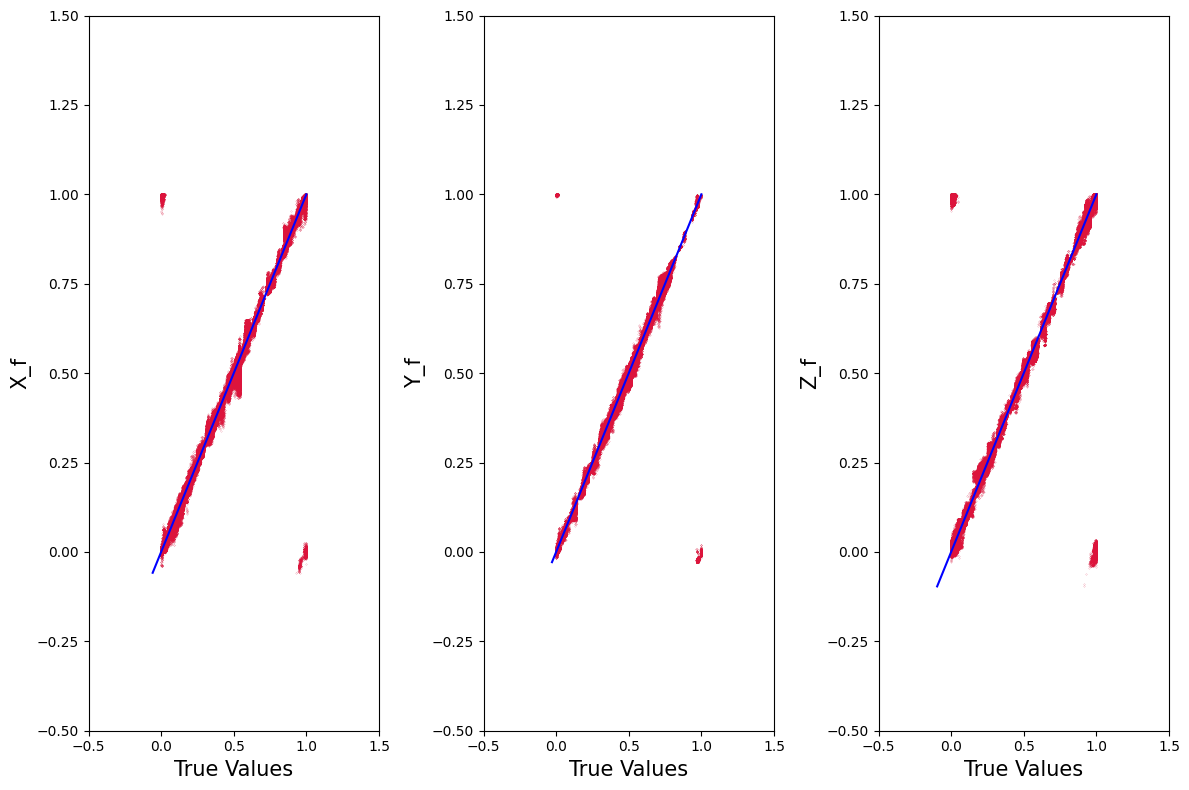

MSE: 0.016435
R2: 0.833


In [28]:
model = xgb.XGBRegressor()
mtype = 'Core'
model.load_model(mtype+'_Extended_v0_Train_Frame20_to_79_Test_Frame80_to_90_nnmodel.json')
ypred, ytrue = model_test(model, X_test), y_test
plot_prediction(ytrue.to_numpy(),ypred.to_numpy(), append = '_'+mtype+'_Extended_v0_Train_Frame20_to_79_Test_Frame80_to_90')
mse = skm.mean_squared_error(ytrue.to_numpy(), ypred.to_numpy())
r2 = skm.r2_score(ytrue.to_numpy(),ypred.to_numpy())
print('MSE: %.6f' % mse)
print('R2: %.3f' % r2)



In [29]:
def mse_modded(y_true, y_pred):
    sqr_diff = np.abs(y_true - y_pred)
    sqr_diff = sqr_diff.flatten()
    sqr_add = 1-np.abs(y_true - y_pred)
    sqr_add = sqr_add.flatten()
    mse = 0
    for i in range(len(sqr_diff)):
        mse += min(sqr_diff[i], sqr_add[i])**2
    return mse/len(sqr_diff)

In [30]:
mse_m = mse_modded(ytrue.to_numpy(), ypred.to_numpy())
print('MSE modded: %.6f' % mse_m)


MSE modded: 0.000154


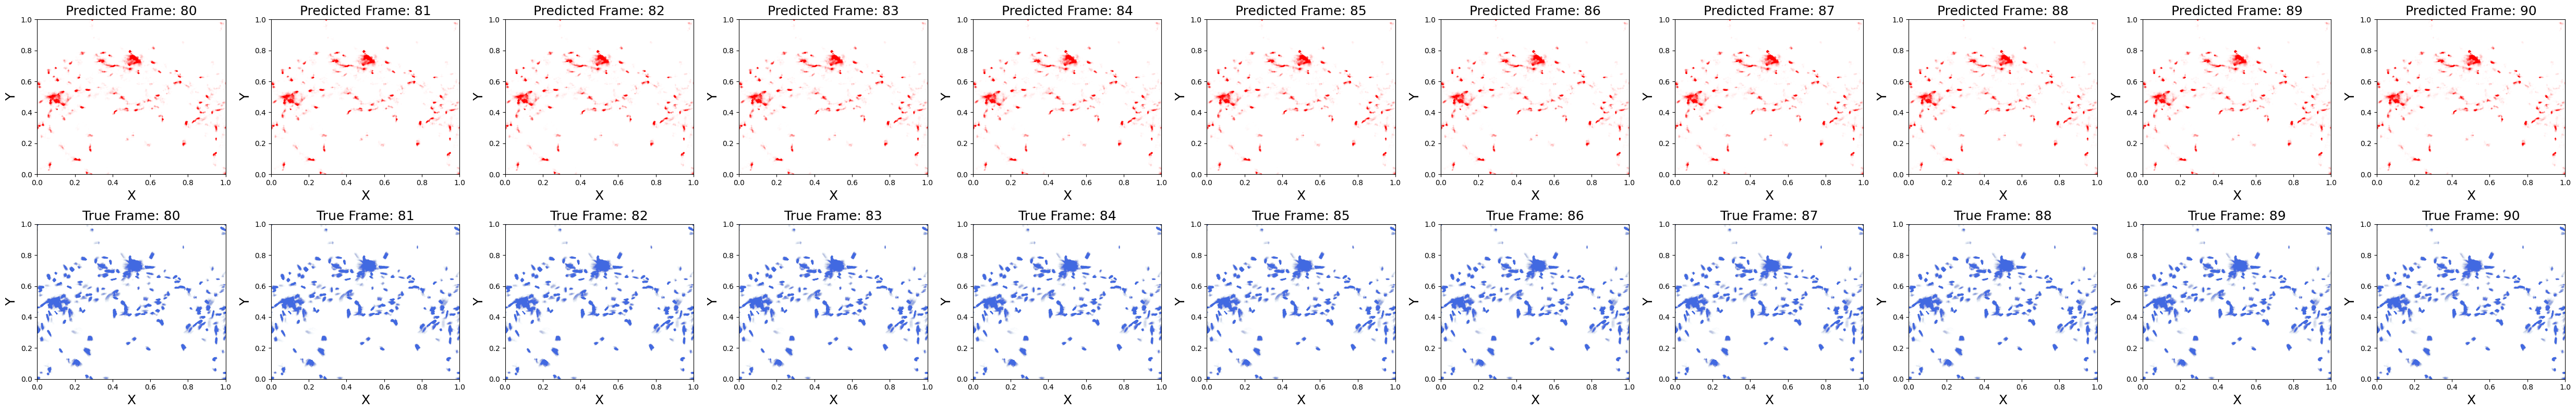

In [42]:
def plot_prediction_framewise(X_test, ypred, ytrue):
    unique_frames = np.unique(X_test['Initial_Frame'])
    fig = plt.figure(figsize=(4.5*len(unique_frames), 8))
    for frame_num_index in range(len(unique_frames)):
        frame_val = unique_frames[frame_num_index]
        X_test_frame = X_test[X_test['Initial_Frame'] == frame_val]
        ypred_frame = ypred.loc[X_test_frame.index]
        ytrue_frame = ytrue.loc[X_test_frame.index]
        ax = plt.subplot2grid((2,len(unique_frames)), (0,frame_num_index))
        ax.set_title(f'Predicted Frame: {frame_val}', fontsize=18)
        ax.set_xlim(0, 1)
        ax.set_xlabel('X', fontsize=18)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Y', fontsize=18)
        ax.scatter(ypred_frame['X_f'], ypred_frame['Y_f'], s=1e-4, color='red')

        ax = plt.subplot2grid((2,len(unique_frames)), (1,frame_num_index))
        ax.set_title(f'True Frame: {frame_val}', fontsize=18)
        ax.set_xlim(0, 1)
        ax.set_xlabel('X', fontsize=18)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Y', fontsize=18)
        ax.scatter(ytrue_frame['X_f'], ytrue_frame['Y_f'], s=1e-4, color='royalblue')
        
    fig.tight_layout()
    plt.savefig('Core_Extended_v0_Train_Frame20_to_79_Test_Frame80_to_90_nnmodel_Prediction_vs_True.png')
    plt.show()

plot_prediction_framewise(X_test, ypred, ytrue)

In [ ]:

#Also do corewise prediction, train on certain cores and predict on other cores

#recursive prediction


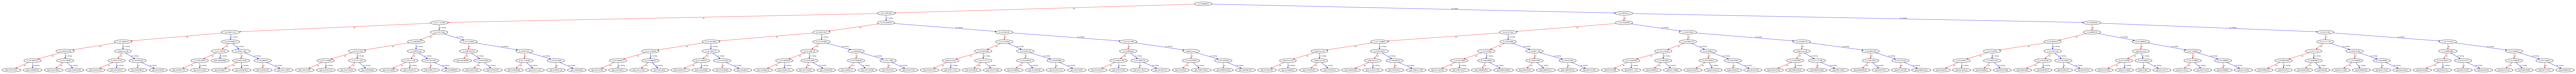

In [423]:
from io import BytesIO
import PIL
fig= plt.subplots(figsize=(210, 90))
g = xgb.to_graphviz(model, num_trees=0, ax=ax1)
s = BytesIO()
s.write(g.pipe(format="eps"))
s.seek(0)
img = np.array(PIL.Image.open(s))
plt.imshow(img)
plt.axis("off")
plt.savefig("Extended_V0_model.png", dpi = 100)
plt.show()

## Stats
| Model 	| Loss 	        | n_estimators 	| max_depth 	| eta 	| subsample 	| lambda 	| alpha 	| Mean MAE 	| mse 	| r2 	| remarks 	                                     |
|-------	|-------        |--------------	|-----------	|-----	|-----------	|--------	|-------	|----------	|------	|----	|---------	                                    |
|Simple V0	|squarederror   |1000           |  7         	|1e-2 	|1/30        	|   1    	|    1  	| 0.023  	|0.005   |0.951	|Fails at periodic wrap                          |
|Simple V1	|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.019 	|0.004  	|0.964	|Suprisingly better than V0                     |
|Simple V2	|squarederror   |1000          	|  7        	|1e-2   | 3/4        	|   1    	|    1  	| 0.019 	|0.004  	|0.963	|Same as V1                                       |
|Periodic V0|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.004 	|0.04  	|-0.882	|Worse than linear fit lol (wrap from 3. to .7)              |
|Periodic V1|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.007 	|0.09  	|-21 lol	|Octant breakdown  doesn't work, individual models are worse off               |
|Extended_V0|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.003     |0.00364|0.968| yay works better for both core and noncore, maybe avg of 2 models shifted?|
|Extended_V0 (trained on 20-50) tested on (80-90)|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.004     |0.044693|0.589| modded mse =  0.001007, not bad! Let's train on more|
|Extended_V0 (trained on 20-79) tested on (80-90)|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.004     |0.016435|0.833| modded mse =  0.000154, yay that's good|